# 사용자 요구사항 기반 메타 프롬프트 생성 에이전트

이 튜토리얼에서는 <mark>사용자가 프롬프트를 생성할 수 있도록 돕는 챗봇을 만드는 방법을 설명</mark>합니다. 챗봇은 먼저 사용자로부터 요구사항을 수집한 후, 이를 바탕으로 프롬프트를 생성하고 사용자 입력에 따라 이를 수정합니다. 이 과정은 두 개의 별도 상태로 나뉘며, LLM이 상태 전환 시점을 결정합니다.

이 시스템의 그래픽 표현은 아래에서 확인할 수 있습니다.

**주로 다루는 내용**

- **Gather information**: 사용자 요구사항 수집을 위한 그래프 정의
- **Generate Prompt**: 프롬프트 생성을 위한 상태 설정
- **Define the state logic**: 챗봇의 상태 논리 정의
- **Create the graph**: 그래프 생성 및 대화 기록 저장
- **Use the graph**: 생성된 챗봇 사용 방법

이 예제에서는 사용자가 프롬프트를 생성할 수 있도록 돕는 챗봇을 만듭니다. 

챗봇은 먼저 사용자로부터 요구사항을 수집한 후, 이를 바탕으로 프롬프트를 생성하고 사용자 입력에 따라 이를 수정합니다. 

이 과정은 두 개의 별도 상태로 나뉘며, LLM이 상태 전환 시점을 결정합니다.

시스템의 그래픽 표현은 아래에서 확인할 수 있습니다.

![meta-prompt-generator.png](assets/meta-prompt-generator.png)

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


## 사용자로부터 요구사항 수집

먼저, 사용자 요구사항을 수집하는 노드를 정의합니다.

이 과정에서 사용자에게 구체적인 정보를 요구할 수 있습니다. 필요한 정보가 모두 **충족** 될 때까지 사용자에게 필요한 정보를 요구합니다.

In [3]:
from typing import List
from langchain_core.messages import SystemMessage
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel
from langchain_teddynote.models import get_model_name, LLMs

# 사용자 요구사항 수집을 위한 시스템 메시지 템플릿
# 당신의 임무는 사용자로부터 어떤 종류의 프롬프트 템플릿을 생성하고 싶어하는지에 대한 정보를 얻는 것입니다.

# 다음 정보를 사용자로부터 얻어야 합니다:

# - 프롬프트의 목표는 무엇인가
# - 어떤 변수들이 프롬프트 템플릿에 전달될 것인가
# - 출력물이 해서는 안 되는 제약 조건은 무엇인가
# - 출력물이 반드시 준수해야 할 요구 사항은 무엇인가

# 만약 이 정보를 파악할 수 없다면, 명확히 해달라고 요청하세요! 섣불리 추측하려고 하지 마세요.

# 모든 정보를 파악한 후에는 관련 도구를 호출하세요.

# [중요] 당신의 대화는 한국어로 진행되어야 합니다. 생성된 프롬프트는 영어로 작성되어야 합니다.

template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool.

[IMPORTANT] Your conversation should be in Korean. Your generated prompt should be in English."""


# 사용자 메시지 목록을 받아 시스템 메시지와 결합하여 반환
def get_messages_info(messages):
    # 사용자 요구사항 수집을 위한 시스템 메시지와 기존 메시지 결합
    return [SystemMessage(content=template)] + messages


# LLM에 대한 프롬프트 지침을 정의하는 데이터 모델
class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    # 프롬프트의 목표
    objective: str
    # 프롬프트 템플릿에 전달될 변수 목록
    variables: List[str]
    # 출력에서 피해야 할 제약 조건 목록
    constraints: List[str]
    # 출력이 반드시 따라야 할 요구 사항 목록
    requirements: List[str]


# 최신 LLM 모델 이름 가져오기
# MODEL_NAME = get_model_name(LLMs.GPT4)
MODEL_NAME = "gemini-2.0-flash-001"
# LLM 초기화
# llm = ChatOpenAI(temperature=0, model=MODEL_NAME)
llm = ChatGoogleGenerativeAI(temperature=0, model=MODEL_NAME)
# PromptInstructions 구조체를 바인딩
llm_with_tool = llm.bind_tools([PromptInstructions])


# 상태 정보를 기반으로 메시지 체인을 생성하고 LLM 호출
def info_chain(state):
    # 상태에서 메시지 정보를 가져와 시스템 메시지와 결합
    messages = get_messages_info(state["messages"])
    # LLM을 호출하여 응답 생성
    response = llm_with_tool.invoke(messages)
    # 생성된 응답을 메시지 목록으로 반환
    return {"messages": [response]}

## 프롬프트 생성

이제 프롬프트를 생성할 상태를 설정합니다. 

이를 위해 별도의 시스템 메시지가 필요하며, 도구 호출 이전의 모든 메시지를 필터링하는 함수도 필요합니다.

여기서 우리가 활용하는 메타 프롬프트의 정의는 아래와 같습니다.

<mark>**메타 프롬프트(Meta Prompt)의 정의**</mark>

<mark>메타 프롬프트(Meta Prompt)는 **프롬프트 설계 및 생성 자체를 최적화하기 위한 방법론이나 전략**을 지칭하는 개념</mark>으로, 인공지능 언어 모델(LLM)을 보다 효과적이고 효율적으로 활용하기 위해 사용됩니다. 단순히 텍스트를 입력하는 것을 넘어, **모델의 반응을 특정 방식으로 유도하거나, 결과의 품질을 높이는 데 필요한 구조적이고 창의적인 접근**을 포함합니다.

**주요 특징**

1. **목표 지향적 구조**  
   메타 프롬프트는 결과로 얻고자 하는 정보를 명확히 정의하고, 이를 위한 단계별 설계 과정을 포함합니다.

2. **적응형 설계**  
   모델의 답변 특성, 한계, 강점을 고려하여 프롬프트를 수정하거나 반복적으로 최적화하는 접근 방식을 포함합니다.

3. **프롬프트 엔지니어링 활용**  
   조건문, 가이드라인, 역할 지시 등을 포함하여 모델의 응답을 세밀하게 조정합니다.

4. **다층적 접근**  
   단일 질문에 그치지 않고, 하위 질문을 통해 답변을 점진적으로 구체화하는 방식을 채택합니다.


- 참고: [OpenAI 메타 프롬프트 엔지니어링 가이드](https://platform.openai.com/docs/guides/prompt-generation?context=text-out)

<details>
    <summary>메타 프롬프트 번역</summary>
주어진 작업 설명 또는 기존 프롬프트를 바탕으로, 언어 모델이 효과적으로 작업을 완료하도록 안내하는 상세한 시스템 프롬프트를 생성합니다.

# 지침

- 작업 이해: 주요 목표, 요구 사항, 제약 조건 및 예상되는 결과물을 파악합니다.
- 최소한의 변경: 기존 프롬프트가 제공된 경우, 간단하다면 개선합니다. 복잡한 프롬프트의 경우, 원래 구조를 변경하지 않고 명확성을 높이고 누락된 요소를 추가합니다.
- 결론 이전 추론**: 결론에 도달하기 전에 추론 단계를 장려합니다. 주의! 사용자가 추론이 나중에 나오는 예제를 제공하는 경우, 순서를 뒤집으세요! 절대 결론으로 예제를 시작하지 마세요!
    - 추론 순서: 프롬프트의 추론 부분과 결론 부분(특정 필드 이름별)을 명확히 구분합니다. 각각에 대해 수행되는 순서를 결정하고, 순서를 뒤집어야 하는지 여부를 결정합니다.
    - 결론, 분류 또는 결과는 항상 마지막에 나타나야 합니다.
- 예제: 복잡한 요소에 대해서는 플레이스홀더([대괄호] 안)를 사용하여 고품질 예제를 포함합니다(도움이 되는 경우).
   - 어떤 종류의 예제를 포함해야 하는지, 몇 개를 포함해야 하는지, 그리고 플레이스홀더를 사용하는 것이 좋을 정도로 복잡한지 여부를 고려합니다.
- 명확성 및 간결성: 명확하고 구체적인 언어를 사용합니다. 불필요한 지침이나 평범한 진술을 피합니다.
- 서식 지정: 가독성을 위해 마크다운 기능을 사용합니다. 특별히 요청하지 않는 한 ``` 코드 블록을 사용하지 마십시오.
- 사용자 콘텐츠 보존: 입력 작업 또는 프롬프트에 광범위한 지침이나 예제가 포함된 경우, 전체 또는 가능한 한 가깝게 보존합니다. 모호한 경우, 하위 단계로 나눕니다. 사용자가 제공한 세부 정보, 지침, 예제, 변수 또는 플레이스홀더를 유지합니다.
- 상수: 프롬프트 주입에 영향을 받지 않으므로 가이드, 루브릭 및 예제와 같은 상수를 포함합니다.
- 출력 형식: 가장 적절한 출력 형식을 자세히 명시합니다. 여기에는 길이와 구문(예: 짧은 문장, 단락, JSON 등)이 포함되어야 합니다.
    - 잘 정의된 또는 구조화된 데이터(분류, JSON 등)를 출력하는 작업의 경우, JSON 출력을 선호합니다.
    - JSON은 명시적으로 요청하지 않는 한 코드 블록(```)으로 래핑되어서는 안 됩니다.

최종 프롬프트는 아래 구조를 준수해야 합니다. 추가 해설을 포함하지 말고, 완료된 시스템 프롬프트만 출력합니다. 특히, 프롬프트의 시작 또는 끝에 추가 메시지를 포함하지 마십시오(예: "---" 없음).

[작업을 설명하는 간결한 지침 - 프롬프트의 첫 번째 줄이어야 하며, 섹션 제목은 없음]

[필요에 따라 추가 세부 정보.]

[자세한 단계를 위한 제목 또는 글머리 기호가 있는 선택적 섹션.]

# 단계 [선택 사항]

[선택 사항: 작업을 수행하는 데 필요한 단계에 대한 자세한 분석]

# 출력 형식

[출력 형식을 구체적으로 지정합니다(응답 길이, 구조(예: JSON, 마크다운 등)).]

[사용자 지정 변수는 {{괄호}}로 묶어야 합니다.]

<질문>
{{question}}
</질문>

<답변>
{{answer}}
</답변>

# 예제 [선택 사항]

[선택 사항: 필요한 경우 플레이스홀더를 사용하여 1-3개의 잘 정의된 예제. 예제의 시작과 끝, 입력과 출력이 무엇인지 명확하게 표시합니다. 필요에 따라 사용자 플레이스홀더를 사용합니다.]
[예제가 현실적인 예제보다 짧은 경우, 실제 예제가 어떻게 더 길거나/짧거나/달라야 하는지 설명하는 참조를 만드세요. 그리고 플레이스홀더를 사용하세요!]

# 참고 사항 [선택 사항]

[선택 사항: 에지 케이스, 세부 정보 및 특정 중요한 고려 사항을 호출하거나 반복하는 영역]

# 다음 요구 사항에 따라 좋은 프롬프트 템플릿을 작성하십시오.

{reqs}
</details>

In [9]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# 프롬프트를 생성하는 메타 프롬프트 정의(OpenAI 메타 프롬프트 엔지니어링 가이드 참고)
META_PROMPT = """Given a task description or existing prompt, produce a detailed system prompt to guide a language model in completing the task effectively.

# Guidelines

- Understand the Task: Grasp the main objective, goals, requirements, constraints, and expected output.
- Minimal Changes: If an existing prompt is provided, improve it only if it's simple. For complex prompts, enhance clarity and add missing elements without altering the original structure.
- Reasoning Before Conclusions**: Encourage reasoning steps before any conclusions are reached. ATTENTION! If the user provides examples where the reasoning happens afterward, REVERSE the order! NEVER START EXAMPLES WITH CONCLUSIONS!
    - Reasoning Order: Call out reasoning portions of the prompt and conclusion parts (specific fields by name). For each, determine the ORDER in which this is done, and whether it needs to be reversed.
    - Conclusion, classifications, or results should ALWAYS appear last.
- Examples: Include high-quality examples if helpful, using placeholders [in brackets] for complex elements.
   - What kinds of examples may need to be included, how many, and whether they are complex enough to benefit from placeholders.
- Clarity and Conciseness: Use clear, specific language. Avoid unnecessary instructions or bland statements.
- Formatting: Use markdown features for readability. DO NOT USE ``` CODE BLOCKS UNLESS SPECIFICALLY REQUESTED.
- Preserve User Content: If the input task or prompt includes extensive guidelines or examples, preserve them entirely, or as closely as possible. If they are vague, consider breaking down into sub-steps. Keep any details, guidelines, examples, variables, or placeholders provided by the user.
- Constants: DO include constants in the prompt, as they are not susceptible to prompt injection. Such as guides, rubrics, and examples.
- Output Format: Explicitly the most appropriate output format, in detail. This should include length and syntax (e.g. short sentence, paragraph, JSON, etc.)
    - For tasks outputting well-defined or structured data (classification, JSON, etc.) bias toward outputting a JSON.
    - JSON should never be wrapped in code blocks (```) unless explicitly requested.

The final prompt you output should adhere to the following structure below. Do not include any additional commentary, only output the completed system prompt. SPECIFICALLY, do not include any additional messages at the start or end of the prompt. (e.g. no "---")

[Concise instruction describing the task - this should be the first line in the prompt, no section header]

[Additional details as needed.]

[Optional sections with headings or bullet points for detailed steps.]

# Steps [optional]

[optional: a detailed breakdown of the steps necessary to accomplish the task]

# Output Format

[Specifically call out how the output should be formatted, be it response length, structure e.g. JSON, markdown, etc]

[User given variables should be wrapped in {{brackets}}]

<Question>
{{question}}
</Question>

<Answer>
{{answer}}
</Answer>

# Examples [optional]

[Optional: 1-3 well-defined examples with placeholders if necessary. Clearly mark where examples start and end, and what the input and output are. User placeholders as necessary.]
[If the examples are shorter than what a realistic example is expected to be, make a reference with () explaining how real examples should be longer / shorter / different. AND USE PLACEHOLDERS! ]

# Notes [optional]

[optional: edge cases, details, and an area to call or repeat out specific important considerations]

# Based on the following requirements, write a good prompt template:

{reqs}
"""


# 프롬프트 생성을 위한 메시지 가져오기 함수
# 도구 호출 이후의 메시지만 가져옴
def get_prompt_messages(messages: list):
    # 도구 호출 정보를 저장할 변수 초기화
    tool_call = None
    # 도구 호출 이후의 메시지를 저장할 리스트 초기화
    other_msgs = []
    # 메시지 목록을 순회하며 도구 호출 및 기타 메시지 처리
    for m in messages:
        # AI 메시지 중 도구 호출이 있는 경우 도구 호출 정보 저장
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        # ToolMessage는 건너뜀
        elif isinstance(m, ToolMessage):
            continue
        # 도구 호출 이후의 메시지를 리스트에 추가
        elif tool_call is not None:
            other_msgs.append(m)
    # 시스템 메시지와 도구 호출 이후의 메시지를 결합하여 반환
    # tool_call이 None인 경우 빈 문자열을 할당하여 오류 방지
    reqs = tool_call if tool_call is not None else ""    
    return [SystemMessage(content=META_PROMPT.format(reqs=tool_call))] + other_msgs


# 프롬프트 생성 체인 함수 정의
def prompt_gen_chain(state):
    # 상태에서 프롬프트 메시지를 가져옴
    messages = get_prompt_messages(state["messages"])
    # LLM을 호출하여 응답 생성
    # messages가 비어 있는지 확인하고, 비어 있다면 오류 메시지 출력
    if not messages:
        print("오류: 메시지 목록이 비어 있습니다.")
        return {"messages": [AIMessage(content="오류: 메시지 목록이 비어 있습니다.")]}    
    response = llm.invoke(messages)
    # 생성된 응답을 메시지 목록으로 반환
    return {"messages": [response]}

## 상태 논리 정의

챗봇의 상태를 결정하는 논리를 설명합니다.

- 마지막 메시지가 `tool call`인 경우, "prompt creator"(`prompt`)가 응답해야 하는 상태에 있습니다.
- 마지막 메시지가 `HumanMessage`가 아닌 경우, 사용자가 다음에 응답해야 하므로 `END` 상태에 있습니다.
- 마지막 메시지가 `HumanMessage`인 경우, 이전에 `tool call`이 있었다면 `prompt` 상태에 있습니다.
- 그렇지 않으면 "정보 수집"(`info`) 상태에 있습니다.

In [10]:
from langgraph.graph import END


# 상태 결정 함수 정의
# 상태에서 메시지 목록을 가져옴
def get_state(state):
    messages = state["messages"]
    # 마지막 메시지가 AIMessage이고 도구 호출이 있는 경우
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        # 도구 메시지를 추가해야 하는 상태 반환
        return "add_tool_message"
    # 마지막 메시지가 HumanMessage가 아닌 경우
    elif not isinstance(messages[-1], HumanMessage):
        # 대화 종료 상태 반환
        return END
    # 기본적으로 정보 수집 상태 반환
    return "info"

## 그래프 생성

이제 그래프를 생성할 수 있습니다. 대화 기록을 저장하기 위해 `MemorySaver`를 사용할 것입니다.

In [11]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import ToolMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 메모리에 대화 기록을 저장하기 위한 MemorySaver 초기화
memory = MemorySaver()

# 상태 그래프 초기화
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


# 도구 메시지 추가 상태 노드 정의
@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0][
                    "id"
                ],  # 상태에서 도구 호출 ID를 가져와 메시지에 추가
            )
        ]
    }


# 조건부 상태 전환 정의
workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])

# 엣지 정의
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# 그래프 컴파일
graph = workflow.compile(checkpointer=memory)

그래프를 시각화합니다.


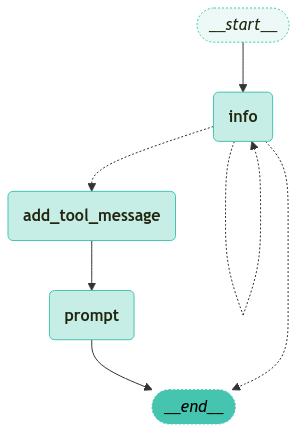

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 실행

이제 생성한 그래프를 실행하여 프롬프트를 생성합니다.

In [1]:
import uuid
from langchain_teddynote.messages import stream_graph

# 구성 설정 초기화 (고유한 thread_id 생성)
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# 무한 루프 시작
while True:
    try:
        # 사용자 입력 받기
        user = input("User (q/Q to quit): ")
    except:
        pass

    # 사용자 입력 출력
    print(f"\n\033[93m[사용자] {user}\033[0m")

    # 'q' 또는 'Q' 입력 시 루프 종료
    if user in {"q", "Q"}:
        print("AI: 다음에 또 만나요!")
        break

    # 출력 변수 초기화
    output = None

    stream_graph(
        graph,
        {"messages": [HumanMessage(content=user)]},
        config=config,
        node_names=["info", "prompt"],
    )


[사용자] 사과에 대한 동화 만들기


NameError: name 'graph' is not defined